# Example-49: Advance (Computation of chromatic phase advances)

In [1]:
# In this example chromatic phase advance are computed (derivatives of phase advance with respect to momentum deviation)

In [2]:
# Import

from pprint import pprint

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt

from model.library.corrector import Corrector
from model.library.line import Line

from model.command.util import chop
from model.command.util import select

from model.command.external import load_sdds
from model.command.external import load_lattice

from model.command.build import build

from model.command.tune import tune
from model.command.advance import advance
from model.command.advance import chromatic_advance

In [3]:
# Load ELEGANT twiss

path = Path('ic.twiss')
parameters, columns = load_sdds(path)

nu_qx:Tensor = torch.tensor(parameters['nux'] % 1, dtype=torch.float64)
nu_qy:Tensor = torch.tensor(parameters['nuy'] % 1, dtype=torch.float64)

# Set phase advances from lattice start to each BPM

kinds = select(columns, 'ElementType', keep=False)

mu_qx = select(columns, 'psix', keep=False)
mu_qy = select(columns, 'psiy' , keep=False)

mu_qx:Tensor = torch.tensor([value for (key, value), kind in zip(mu_qx.items(), kinds.values()) if kind == 'MONI'], dtype=torch.float64)
mu_qy:Tensor = torch.tensor([value for (key, value), kind in zip(mu_qy.items(), kinds.values()) if kind == 'MONI'], dtype=torch.float64)

positions = select(columns, 's', keep=False).items()
positions = [value for (key, value), kind in zip(positions, kinds.values()) if kind == 'MONI']

In [4]:
# Build and setup lattice

# Load ELEGANT table

path = Path('ic.lte')
data = load_lattice(path)

# Build ELEGANT table

ring:Line = build('RING', 'ELEGANT', data)
ring.flatten()

# Merge drifts

ring.merge()

# Split BPMs

ring.split((None, ['BPM'], None, None))

# Roll lattice start

ring.roll(1)

# Set linear dipoles

for element in ring:
    if element.__class__.__name__ == 'Dipole':
        element.linear = True

# Split lattice into lines by BPMs

ring.splice()

# Set number of elements of different kinds

nb = ring.describe['BPM']
nq = ring.describe['Quadrupole']
ns = ring.describe['Sextupole']

In [5]:
# Compute tunes (fractional part)

guess = torch.tensor(4*[0.0], dtype=torch.float64)
nuqx, nuqy = tune(ring, [], alignment=False, matched=True, guess=guess, limit=8, epsilon=1.0E-9)

# Compare with elegant

print(torch.allclose(nu_qx, nuqx))
print(torch.allclose(nu_qy, nuqy))

True
True


In [6]:
# Compute chromatic phase advances

dp = torch.tensor([0.0], dtype=torch.float64)
dmuqxdp, dmuqydp = response = chromatic_advance(ring, [], alignment=False, matched=True, limit=16, epsilon=None).T

In [7]:
# Test derivatives

dp = torch.tensor([0.001], dtype=torch.float64)

model = advance(ring, [0.0*dp], ('dp', None, None, None), alignment=False, matched=True, limit=16, epsilon=None).T
error = advance(ring, [1.0*dp], ('dp', None, None, None), alignment=False, matched=True, limit=16, epsilon=None).T

print((error - model).norm())
print((error - (model + response * dp)).norm())

tensor(0.0805, dtype=torch.float64)
tensor(0.0013, dtype=torch.float64)


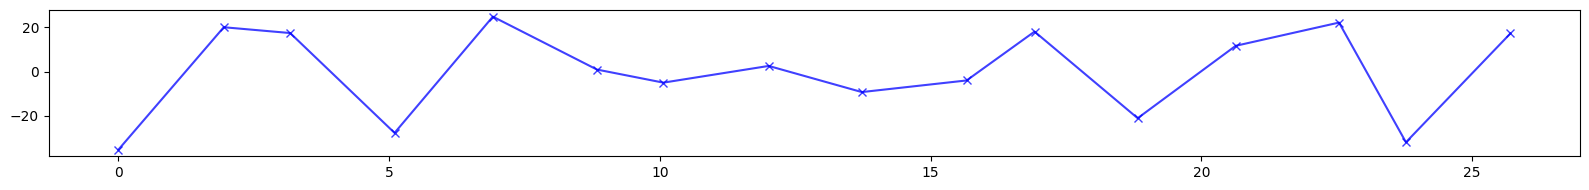

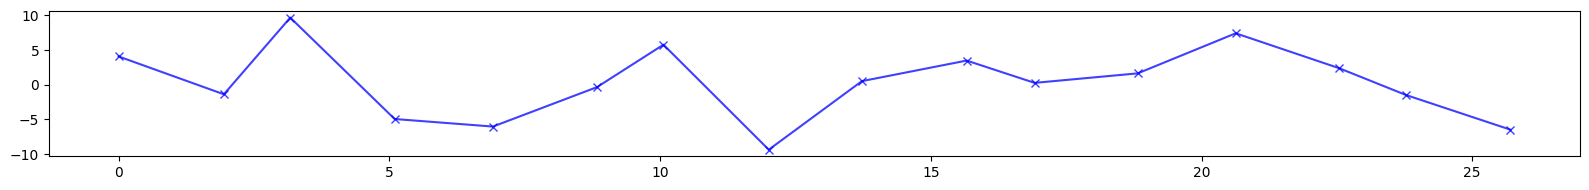

In [8]:
# Plot and compare chromatic phase advances

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), dmuqxdp.cpu().numpy(), fmt='-', color='blue', marker='x', alpha=0.75)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 2))
plt.errorbar(ring.locations().cpu().numpy(), dmuqydp.cpu().numpy(), fmt='-', color='blue', marker='x', alpha=0.75)
plt.tight_layout()
plt.show()